In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.model_selection as ms
import sklearn.preprocessing as pp
import sklearn.metrics as metrics
from sklearn import svm
from sklearn import pipeline
from sklearn import decomposition
import matplotlib.pyplot as plt
import pickle
import scipy as sp
import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

### Auxiliary functions

In [2]:
def salt_pepper(data, pixel_percent):
    data_kill = data.copy()
    n_pixels = data[0].shape[0]*data[0].shape[1]
    n_pixels_to_kill = int(n_pixels * pixel_percent/100)
    for i in range(len(data)):
        for j in range(n_pixels_to_kill):
            data_kill[i][np.random.randint(data[i].shape[0])][np.random.randint(data[i].shape[1])] = np.random.randint(2)
    return data_kill

### Load the data

In [3]:
with open('./faces_dict.p', 'rb') as f:
    faces_data = pickle.load(f)

### Data exploration

We've got three columns and 400 rows of data. Each row has its image (64 pixels x 64 pixels, each quantized in a [0,1] grey level) , the same data in a vector form (4096 pixels), and a number indicating who is in the picture. We have 10 images of each person, 40 people in total. Below we can see an image of each person.

dict_keys(['data', 'images', 'target'])
Shape 'data': (400, 4096)
Shape 'images': (400, 64, 64)
Shape 'target': (400,)
First row 'data': [0.30991736 0.3677686  0.41735536 ... 0.15289256 0.16115703 0.1570248 ]
First row 'images': [[0.30991736 0.3677686  0.41735536 ... 0.37190083 0.3305785  0.30578512]
 [0.3429752  0.40495867 0.43801653 ... 0.37190083 0.338843   0.3140496 ]
 [0.3429752  0.41735536 0.45041323 ... 0.38016528 0.338843   0.29752067]
 ...
 [0.21487603 0.20661157 0.2231405  ... 0.15289256 0.16528925 0.17355372]
 [0.20247933 0.2107438  0.2107438  ... 0.14876033 0.16115703 0.16528925]
 [0.20247933 0.20661157 0.20247933 ... 0.15289256 0.16115703 0.1570248 ]]
Ammount of photos of each person: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10, 16: 10, 17: 10, 18: 10, 19: 10, 20: 10, 21: 10, 22: 10, 23: 10, 24: 10, 25: 10, 26: 10, 27: 10, 28: 10, 29: 10, 30: 10, 31: 10, 32: 10, 33: 10, 34: 10, 35: 10, 36: 10, 37: 10

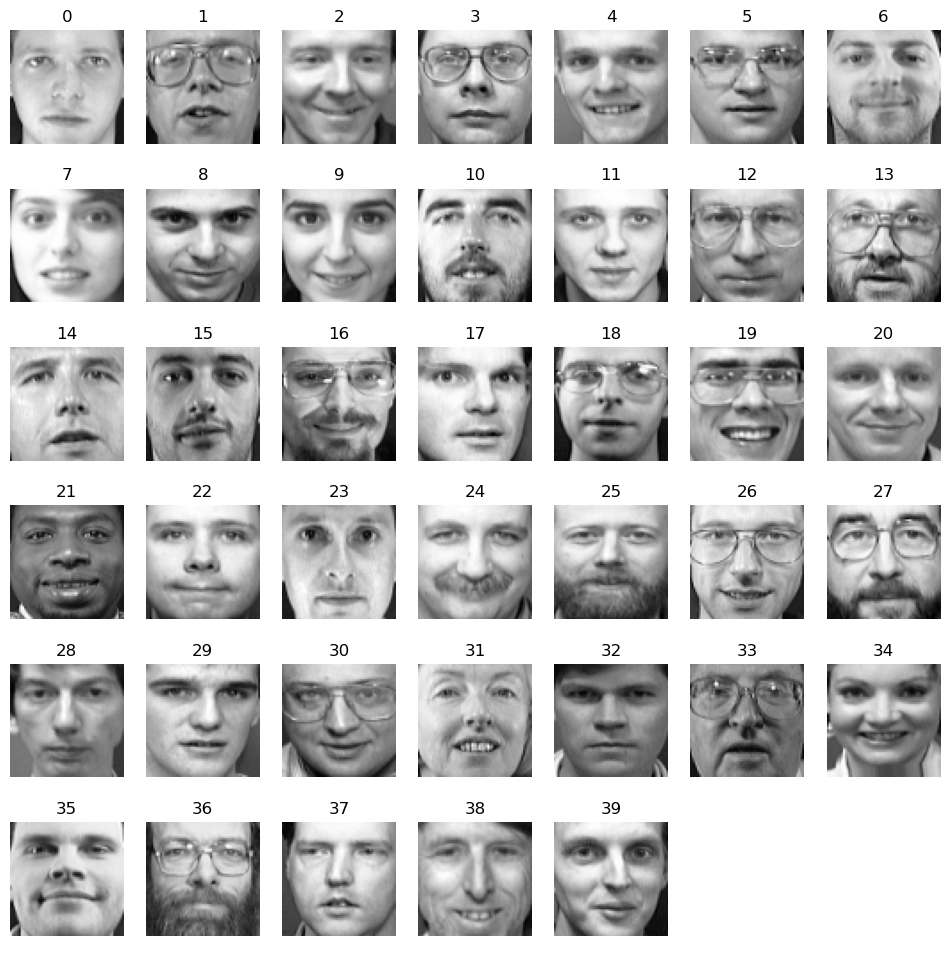

In [4]:
print(faces_data.keys())
print("Shape 'data': "+str(faces_data['data'].shape))
print("Shape 'images': "+str(faces_data['images'].shape))
print("Shape 'target': "+str(faces_data['target'].shape))

print("First row 'data': "+str(faces_data['data'][0]))
print("First row 'images': "+str(faces_data['images'][0]))

unique, counts = np.unique(faces_data['target'], return_counts=True)
print("Ammount of photos of each person: "+str(dict(zip(unique, counts))))


fig, ax=plt.subplots(6, 7, figsize=(12, 12))
cont_i=0
cont_j=0
for i in range(40):
    ax[cont_i, cont_j].imshow(faces_data['images'][10*i], cmap='gray')
    ax[cont_i, cont_j].set_title(faces_data['target'][10*i])
    cont_j+=1
    if cont_j==7:
        cont_j=0
        cont_i+=1
for i in range(6):
    for j in range(7):
        ax[i, j].axis('off')
plt.show()

### Split train and test sets

First we split our data into train (70%) and test (30%) sets, and store the test set aside for later. We will be working with the train set only for now. 

We also copy a portion of the train set to a validation set, which we will use for the CNN. The reason for this is so as not to have manipulated data on the validation set of the CNN, which we will use to test the CNN's performance on non-agumented data it has not seen before, as the epochs advance.

In [4]:
X_train, X_test, y_train, y_test = ms.train_test_split(faces_data['data'], faces_data['target'], test_size=0.3, stratify=faces_data['target'],random_state=10)

#For the CNN
x_train_val_CNN = X_train[:500]
y_train_val_CNN = y_train[:500]
x_train_val_CNN_2d = x_train_val_CNN.reshape(x_train_val_CNN.shape[0], 64, 64, 1)
y_train_val_CNN_2d = to_categorical(y_train_val_CNN)

### Data augmentation

Given that we only have less than 7 images per person (in the train set, we leave the validation set untouched for later), we need to augment the data, especially for the convolutional neural network model. For each image in the training set, we will create an horizontally-reflected copy. Then we will create a darkened copy of each one of them via gamma-correction ($I_{new}=I^{\gamma},\,\gamma=3$). Next, we generate a blurred copy of each image using a Gaussian filter with $\sigma=0.65$. Lastly, we will create a copy of each image with 5% of the pixels randomly set to 0 or 1 (salt & pepper filter). This way we end up with 16 images generated from each image of a person, so our augmented train test consists of 4480 faces instead of 280. 

Below we can see all the data generated from a single example image, and we verify that our training test contains 112 images of each person (clearly there is no class imbalance).

Once the train set is augmented, we copy every image not included in the CNN validation set to the partial train set, which we will be using to train the CNN. This way we end up with an augmented train set, and an unalterated validation set (for the CNN).

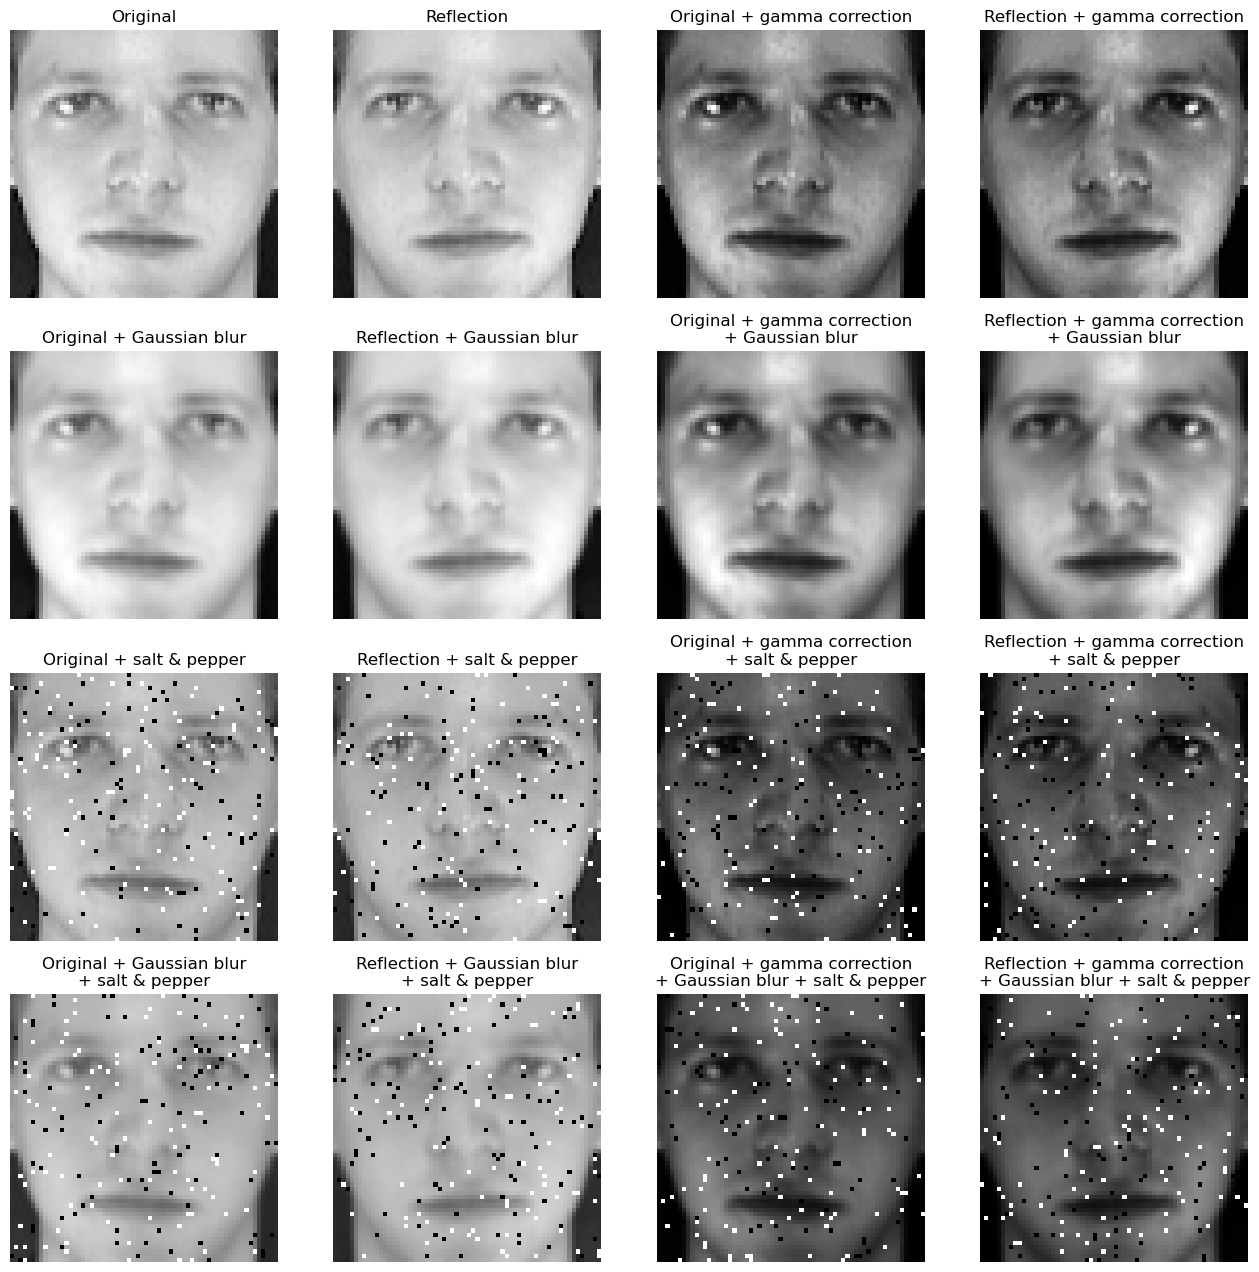

In [66]:
imagen_orig=np.copy(faces_data['images'][0])

#horizontal reflection
imagen_reflected = np.copy(imagen_orig)
imagen_reflected = np.flip(imagen_reflected, axis=1)

#gamma correction
imagen_orig_gamma = np.copy(imagen_orig)
imagen_orig_gamma = imagen_orig_gamma**3
imagen_reflected_gamma = np.copy(imagen_reflected)
imagen_reflected_gamma = imagen_reflected_gamma**3

#gaussian 
imagen_orig_blurred=np.copy(imagen_orig)
imagen_orig_blurred = sp.ndimage.gaussian_filter(imagen_orig_blurred, sigma=0.65)
imagen_reflected_blurred=np.copy(imagen_reflected)
imagen_reflected_blurred = sp.ndimage.gaussian_filter(imagen_reflected_blurred, sigma=0.65)
imagen_orig_gamma_blurred=np.copy(imagen_orig_gamma)
imagen_orig_gamma_blurred = sp.ndimage.gaussian_filter(imagen_orig_gamma_blurred, sigma=0.65)
imagen_reflected_gamma_blurred=np.copy(imagen_reflected_gamma)
imagen_reflected_gamma_blurred = sp.ndimage.gaussian_filter(imagen_reflected_gamma_blurred, sigma=0.65)

#salt and pepper
imagen_orig_kill=np.copy(imagen_orig)
imagen_orig_kill = salt_pepper([imagen_orig_kill], 5)
imagen_reflected_kill=np.copy(imagen_reflected)
imagen_reflected_kill = salt_pepper([imagen_reflected_kill], 5)
imagen_orig_gamma_kill=np.copy(imagen_orig_gamma)
imagen_orig_gamma_kill = salt_pepper([imagen_orig_gamma_kill], 5)
imagen_reflected_gamma_kill=np.copy(imagen_reflected_gamma)
imagen_reflected_gamma_kill = salt_pepper([imagen_reflected_gamma_kill], 5)
imagen_orig_blurred_kill=np.copy(imagen_orig_blurred)
imagen_orig_blurred_kill = salt_pepper([imagen_orig_blurred_kill], 5)
imagen_reflected_blurred_kill=np.copy(imagen_reflected_blurred)
imagen_reflected_blurred_kill = salt_pepper([imagen_reflected_blurred_kill], 5)
imagen_orig_gamma_blurred_kill=np.copy(imagen_orig_gamma_blurred)
imagen_orig_gamma_blurred_kill = salt_pepper([imagen_orig_gamma_blurred_kill], 5)
imagen_reflected_gamma_blurred_kill=np.copy(imagen_reflected_gamma_blurred)
imagen_reflected_gamma_blurred_kill = salt_pepper([imagen_reflected_gamma_blurred_kill], 5)

fig, ax=plt.subplots(4,4, figsize=(16, 16))

ax[0,0].imshow(imagen_orig, cmap='gray')
ax[0,0].set_title("Original")
ax[0,0].axis('off')
ax[0,1].imshow(imagen_reflected, cmap='gray')
ax[0,1].set_title("Reflection")
ax[0,1].axis('off')
ax[0,2].imshow(imagen_orig_gamma, cmap='gray')
ax[0,2].set_title("Original + gamma correction")
ax[0,2].axis('off')
ax[0,3].imshow(imagen_reflected_gamma, cmap='gray')
ax[0,3].set_title("Reflection + gamma correction")
ax[0,3].axis('off')
ax[1,0].imshow(imagen_orig_blurred, cmap='gray')
ax[1,0].set_title("Original + Gaussian blur")
ax[1,0].axis('off')
ax[1,1].imshow(imagen_reflected_blurred, cmap='gray')
ax[1,1].set_title("Reflection + Gaussian blur")
ax[1,1].axis('off')
ax[1,2].imshow(imagen_orig_gamma_blurred, cmap='gray')
ax[1,2].set_title("Original + gamma correction\n+ Gaussian blur")
ax[1,2].axis('off')
ax[1,3].imshow(imagen_reflected_gamma_blurred, cmap='gray')
ax[1,3].set_title("Reflection + gamma correction\n+ Gaussian blur")
ax[1,3].axis('off')

ax[2,0].imshow(imagen_orig_kill[0], cmap='gray')
ax[2,0].set_title("Original + salt & pepper")
ax[2,0].axis('off')
ax[2,1].imshow(imagen_reflected_kill[0], cmap='gray')
ax[2,1].set_title("Reflection + salt & pepper")
ax[2,1].axis('off')
ax[2,2].imshow(imagen_orig_gamma_kill[0], cmap='gray')
ax[2,2].set_title("Original + gamma correction\n+ salt & pepper")
ax[2,2].axis('off')
ax[2,3].imshow(imagen_reflected_gamma_kill[0], cmap='gray')
ax[2,3].set_title("Reflection + gamma correction\n+ salt & pepper")
ax[2,3].axis('off')
ax[3,0].imshow(imagen_orig_blurred_kill[0], cmap='gray')
ax[3,0].set_title("Original + Gaussian blur\n+ salt & pepper")
ax[3,0].axis('off')
ax[3,1].imshow(imagen_reflected_blurred_kill[0], cmap='gray')
ax[3,1].set_title("Reflection + Gaussian blur\n+ salt & pepper")
ax[3,1].axis('off')
ax[3,2].imshow(imagen_orig_gamma_blurred_kill[0], cmap='gray')
ax[3,2].set_title("Original + gamma correction\n+ Gaussian blur + salt & pepper")
ax[3,2].axis('off')
ax[3,3].imshow(imagen_reflected_gamma_blurred_kill[0], cmap='gray')
ax[3,3].set_title("Reflection + gamma correction\n+ Gaussian blur + salt & pepper")
ax[3,3].axis('off')

plt.show()


In [5]:
X_train_augmented=np.copy(X_train)
y_train_augmented=np.copy(y_train)

#horizontal reflection
images_reflected = np.array([np.reshape(x, (64,64)) for x in X_train_augmented])
images_reflected = np.flip(images_reflected, axis=2)
X_train_augmented = np.concatenate((X_train_augmented, images_reflected.reshape(images_reflected.shape[0], -1)), axis=0)
y_train_augmented = np.concatenate((y_train_augmented, y_train_augmented), axis=0)

#gamma correction
X_train_augmented=np.concatenate((X_train_augmented, X_train_augmented**3), axis=0)
y_train_augmented=np.concatenate((y_train_augmented, y_train_augmented), axis=0)

#gaussian 
images_blurred=np.array([np.reshape(x, (64,64)) for x in X_train_augmented])
for i in range(len(images_blurred)):
    images_blurred[i]=sp.ndimage.gaussian_filter(images_blurred[i], sigma=0.65)
X_train_augmented=np.concatenate((X_train_augmented, images_blurred.reshape(images_blurred.shape[0], -1)), axis=0)
y_train_augmented=np.concatenate((y_train_augmented, y_train_augmented), axis=0)

#salt and pepper
images_dead_pixels=salt_pepper(np.array([np.reshape(x, (64,64)) for x in X_train_augmented]), 5)
X_train_augmented=np.concatenate((X_train_augmented, images_dead_pixels.reshape(images_dead_pixels.shape[0],-1)), axis=0)
y_train_augmented=np.concatenate((y_train_augmented, y_train_augmented), axis=0)

#For the CNN
partial_x_train_CNN=[]
partial_y_train_CNN=[]
for i in range(len(X_train_augmented)):
    if X_train_augmented[i] not in x_train_val_CNN:
        partial_x_train_CNN.append(X_train_augmented[i])
        partial_y_train_CNN.append(y_train_augmented[i])
partial_x_train_CNN=np.array(partial_x_train_CNN)
partial_y_train_CNN=np.array(partial_y_train_CNN)
partial_x_train_CNN_2d = partial_x_train_CNN.reshape(partial_x_train_CNN.shape[0], 64, 64, 1)
partial_y_train_CNN_2d = to_categorical(partial_y_train_CNN)

In [6]:
print(pd.Series(y_train_augmented).value_counts().sort_index())

0     112
1     112
2     112
3     112
4     112
5     112
6     112
7     112
8     112
9     112
10    112
11    112
12    112
13    112
14    112
15    112
16    112
17    112
18    112
19    112
20    112
21    112
22    112
23    112
24    112
25    112
26    112
27    112
28    112
29    112
30    112
31    112
32    112
33    112
34    112
35    112
36    112
37    112
38    112
39    112
dtype: int64


### Train Support Vector Machine classifier pipeline with default hiperparameters

We define a classic SVM classifier pipeline consisting in a standard scaling step (to have zero mean and unit variance), a PCA step (to reduce the dimensionality of the data), and lastly a SVM classifier. The reason why I chose to implement a SVM classifier is because it is a very good general purpose classifier, widely used in face classification problems (with multiple classes), performs well with relatively small training sets, and it is very fast to train.

First, we use the default hyperparameters for each step, and we train the pipeline on the augmented train set. I also tried to train the pipeline on the original train set, but the results were slightly worse.

In [8]:
pipe = pipeline.Pipeline([('scaler', pp.StandardScaler()), ('pca', decomposition.PCA()), ('svc', svm.SVC())])
svm_classifier = pipe.fit(X_train_augmented, y_train_augmented)

### Evaluate the model's performance on the train 

Now we evaluate the model's performance on the train set, and we can see that the model has a 100% accuracy on the train set. Then we perform a 3-fold cross-validation on the train set, and we can see that the model also has a 100% accuracy.

This might be a sign of overfitting, but it is important to notice that, when performing the cross-validation, the validation set in each fold might contain manipulated data (augmented data). This is not the case for the test set, so we might be overestimating the model's performance. Anyway, I asume that the applied transformations are not too drastic, so the model should be able to generalize well to the test set, as we will check later on.

In [57]:
print(metrics.classification_report(y_train_augmented, svm_classifier.predict(X_train_augmented)))

scores = ms.cross_val_score(pipe, X_train_augmented, y_train_augmented, cv=3, scoring='f1_macro')
print("3-fold cross-validation score: "+str(round(scores.mean(),2))+" +/- "+str(round(scores.std(),2)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       112
           1       1.00      1.00      1.00       112
           2       1.00      1.00      1.00       112
           3       1.00      1.00      1.00       112
           4       1.00      1.00      1.00       112
           5       1.00      1.00      1.00       112
           6       1.00      1.00      1.00       112
           7       1.00      1.00      1.00       112
           8       1.00      1.00      1.00       112
           9       1.00      1.00      1.00       112
          10       1.00      1.00      1.00       112
          11       1.00      1.00      1.00       112
          12       1.00      1.00      1.00       112
          13       1.00      1.00      1.00       112
          14       1.00      1.00      1.00       112
          15       1.00      1.00      1.00       112
          16       1.00      1.00      1.00       112
          17       1.00    

### Hyperparameter optimization with GridSearchCV

Now we perform a grid search over the hyperparameters of the PCA and the SVM classifier. We will be using a 3-fold cross-validation on the augmented train set, and we will be optimizing the accuracy metric. We try 3 different values of components reduction, and 5 different values of the regularization parameter C.

In [9]:
param_grid = {'svc__C': [0.1, 0.5, 1, 5, 10], 'pca__n_components': [0.7,0.8,0.9], 'svc__kernel': ['rbf']}
grid = ms.GridSearchCV(pipe, param_grid, refit=True,verbose=3, cv=3,scoring='f1_macro')
grid.fit(X_train_augmented, y_train_augmented)
print(grid.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END pca__n_components=0.7, svc__C=0.1, svc__kernel=rbf;, score=0.432 total time=  16.7s
[CV 2/3] END pca__n_components=0.7, svc__C=0.1, svc__kernel=rbf;, score=0.246 total time=  12.1s
[CV 3/3] END pca__n_components=0.7, svc__C=0.1, svc__kernel=rbf;, score=0.047 total time=  15.9s
[CV 1/3] END pca__n_components=0.7, svc__C=0.5, svc__kernel=rbf;, score=0.908 total time=  10.7s
[CV 2/3] END pca__n_components=0.7, svc__C=0.5, svc__kernel=rbf;, score=0.517 total time=  14.9s
[CV 3/3] END pca__n_components=0.7, svc__C=0.5, svc__kernel=rbf;, score=0.087 total time=  10.1s
[CV 1/3] END pca__n_components=0.7, svc__C=1, svc__kernel=rbf;, score=0.946 total time=  14.3s
[CV 2/3] END pca__n_components=0.7, svc__C=1, svc__kernel=rbf;, score=0.616 total time=  10.2s
[CV 3/3] END pca__n_components=0.7, svc__C=1, svc__kernel=rbf;, score=0.128 total time=  14.8s
[CV 1/3] END pca__n_components=0.7, svc__C=5, svc__kernel=rbf;, score=0.

### Train Support Vector Machine with optimized hyperparameters

We train the model using the optimized hyperparameters, and we can see that the model has a 100% accuracy on the train set, as well as on the 3-fold cross validation. We can se that there is no notable improvement in the model's performance.

In [12]:
pipe_gs = pipeline.Pipeline([('pca', decomposition.PCA(n_components=0.9)), ('svc', svm.SVC(C=1, kernel='rbf'))])
svm_classifier_gs = pipe_gs.fit(X_train_augmented, y_train_augmented)

In [13]:
print(metrics.classification_report(y_train_augmented, svm_classifier_gs.predict(X_train_augmented)))

scores = ms.cross_val_score(pipe_gs, X_train_augmented, y_train_augmented, cv=3, scoring='f1_macro')
print("3-fold cross-validation score: "+str(round(scores.mean(),2))+" +/- "+str(round(scores.std(),2)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       112
           1       1.00      1.00      1.00       112
           2       1.00      1.00      1.00       112
           3       1.00      1.00      1.00       112
           4       1.00      1.00      1.00       112
           5       1.00      1.00      1.00       112
           6       1.00      1.00      1.00       112
           7       1.00      1.00      1.00       112
           8       1.00      1.00      1.00       112
           9       1.00      1.00      1.00       112
          10       1.00      1.00      1.00       112
          11       1.00      1.00      1.00       112
          12       1.00      1.00      1.00       112
          13       1.00      1.00      1.00       112
          14       1.00      1.00      1.00       112
          15       1.00      1.00      1.00       112
          16       1.00      1.00      1.00       112
          17       1.00    

### Evaluate the hyperparameter-optimized model's performance on the test set

Finally we evaluate the model's performance on the test set (not augmented), and we can see that the model has aproximately a 98% accuracy. This suggests that the model is not overfitting, and that it is able to generalize well to the test set, even though we generated new training data.

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       0.75      1.00      0.86         3
           8       1.00      1.00      1.00         3
           9       1.00      0.67      0.80         3
          10       1.00      1.00      1.00         3
          11       0.75      1.00      0.86         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00         3
          17       1.00    

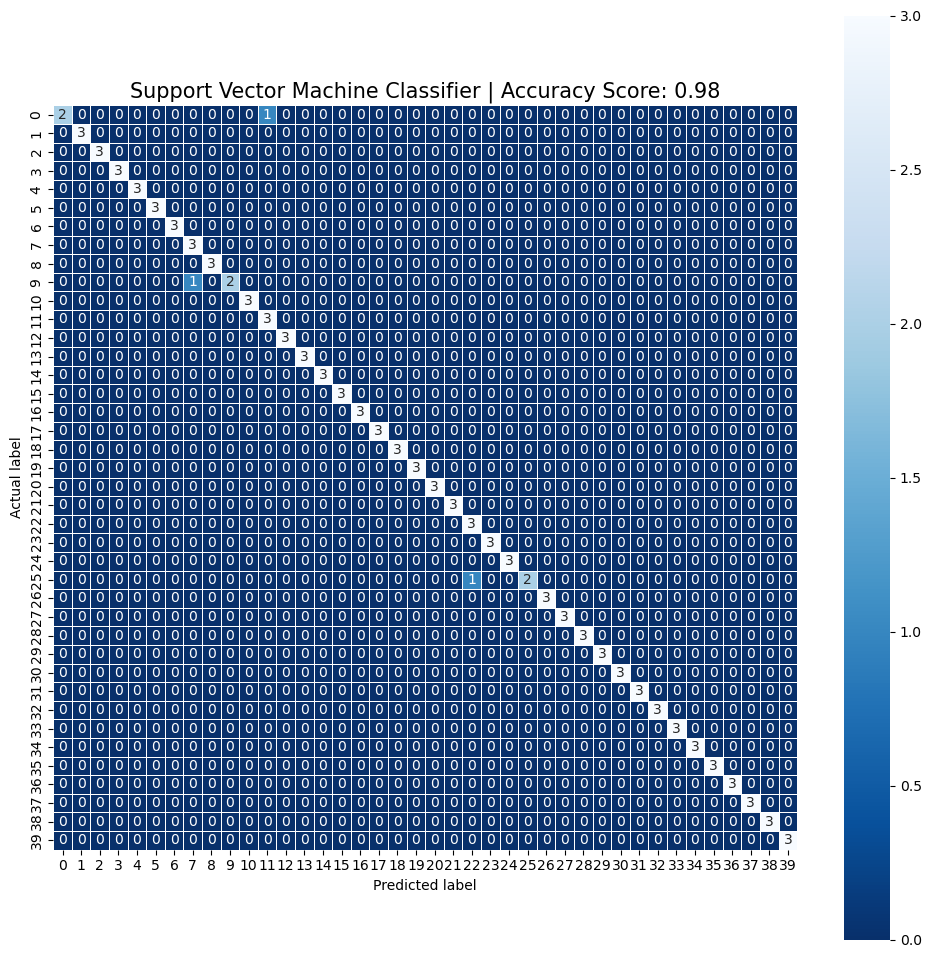

In [14]:
print(metrics.classification_report(y_test, svm_classifier_gs.predict(X_test)))
cm = metrics.confusion_matrix(y_test, svm_classifier_gs.predict(X_test))
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Support Vector Machine Classifier | Accuracy Score: {0}'.format(round(metrics.accuracy_score(y_test, svm_classifier_gs.predict(X_test)),2))
plt.title(all_sample_title, size = 15)
plt.show()

### Save the Support Vector Machine model

In [99]:
pickle.dump(svm_classifier_gs, open('svm_classifier.pkl', 'wb'))

### Build a convolutional neural network

Now we tackle this classification problem with a single layer convolutional neural network.

After playing arround with the model's architecture, I found that the best model (in terms of accuracy) is a single layer CNN with 32 filters, a 3x3 kernel, and a leaky ReLU activation function. The model has a 2x2 max pooling layer, and a softmax activated dense layer so as to return the probability that the input image corresponds to each class. I also tried a CNN with two convolutional layers, but the model's accuracy practically the same as the single layer CNN, so I decided to go with the simpler model.

 The model is trained for 15 epochs, and the batch size is 32. The model is trained using the Adam optimizer, and the loss function is the categorical crossentropy, which is compatible with the softmax activation of the output layer. The model is trained on the augmented partial train set, and the validation set is the unaltered subset of the train set.

In [22]:
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='leaky_relu', input_shape=(64,64,1)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(40, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_model2():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='leaky_relu', input_shape=(64,64,1)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='leaky_relu',input_shape=(32,32,1)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(40, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [60]:
model=create_model()

X_train_augmented_2d = X_train_augmented.reshape(X_train_augmented.shape[0], 64, 64, 1)
y_train_augmented_2d = to_categorical(y_train_augmented)

X_test_2d = X_test.reshape(X_test.shape[0], 64, 64, 1)
y_test_2d = to_categorical(y_test)

#the validation data is NOT augmented, nor present in the partial train set
history = model.fit(partial_x_train_CNN_2d, partial_y_train_CNN_2d, epochs=15, batch_size=32,validation_data=(x_train_val_CNN_2d, y_train_val_CNN_2d))


Epoch 1/15
102/102 [==============================] - 23s 166ms/step - loss: 2.6492 - accuracy: 0.4110 - val_loss: 1.4727 - val_accuracy: 0.6250
Epoch 2/15
102/102 [==============================] - 17s 162ms/step - loss: 0.3664 - accuracy: 0.9531 - val_loss: 0.2445 - val_accuracy: 0.9786
Epoch 3/15
102/102 [==============================] - 14s 139ms/step - loss: 0.0713 - accuracy: 0.9966 - val_loss: 0.1566 - val_accuracy: 0.9786
Epoch 4/15
102/102 [==============================] - 15s 142ms/step - loss: 0.0334 - accuracy: 0.9975 - val_loss: 0.0644 - val_accuracy: 1.0000
Epoch 5/15
102/102 [==============================] - 14s 136ms/step - loss: 0.0148 - accuracy: 1.0000 - val_loss: 0.0228 - val_accuracy: 1.0000
Epoch 6/15
102/102 [==============================] - 15s 149ms/step - loss: 0.0099 - accuracy: 0.9997 - val_loss: 0.0256 - val_accuracy: 0.9964
Epoch 7/15
102/102 [==============================] - 15s 145ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0188 - val_ac

### Looking for signs of overfitting/underfitting

In order to look for signs of overfitting/underfitting, we plot the accuracy and the loss of the model on the train and validation sets as a function of the epochs. We can see that the model is not overfitting, as the accuracy and the loss on the validation set are very similar to those on the train set. The model is also not underfitting, as the accuracy tends to increase as the epochs advance, and the loss tends to decrease. We can also interpret that the model trained with agumented data is able to generalize well to the validation set, since the curves are very similar.

Given that the curves reach a platau at arrond 5 epochs, we could have stopped the training at that point.

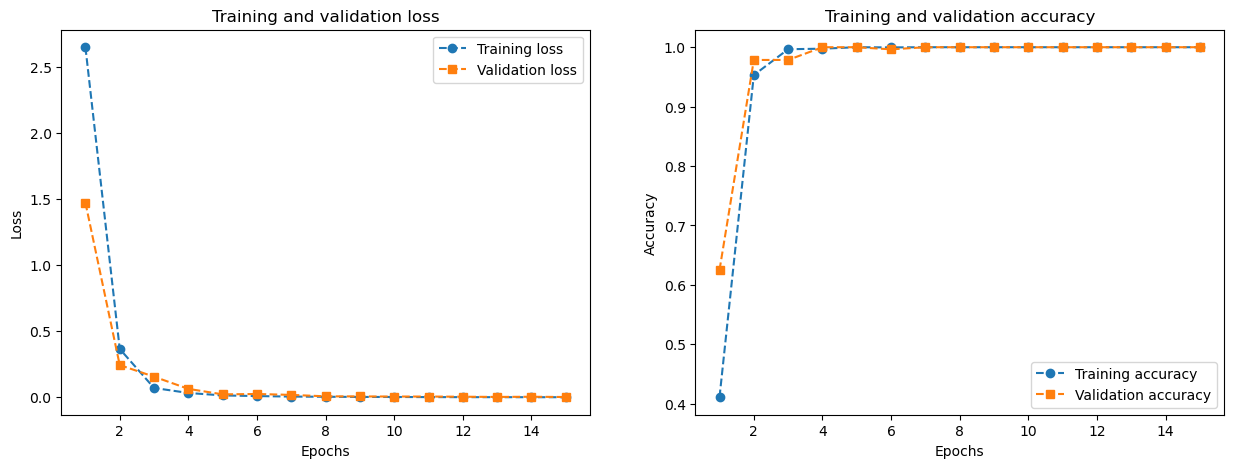

In [91]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
#plot loss and val_loss vs epochs in one ax, and acc and val_acc vs epochs in the other ax
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(epochs, loss, ls="--", marker='o', label="Training loss")
ax1.plot(epochs, val_loss, ls="--", marker='s',label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(epochs, acc, ls='--', marker='o',label="Training accuracy")
ax2.plot(epochs, val_acc, ls='--', marker='s',label="Validation accuracy")
ax2.set_title("Training and validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()
plt.show()

### Retrain the neural network with 6 epochs, using the complete training set

Now we will train the model with 6 epochs, using the complete augmented train set instead of the partial train set.

In [64]:
model_final=create_model()
model_final.fit(X_train_augmented_2d, y_train_augmented_2d, epochs=6, batch_size=32)

Epoch 1/6
140/140 [==============================] - 21s 139ms/step - loss: 2.2220 - accuracy: 0.5116
Epoch 2/6
140/140 [==============================] - 18s 127ms/step - loss: 0.1759 - accuracy: 0.9770
Epoch 3/6
140/140 [==============================] - 19s 135ms/step - loss: 0.0298 - accuracy: 0.9993
Epoch 4/6
140/140 [==============================] - 18s 131ms/step - loss: 0.0123 - accuracy: 1.0000
Epoch 5/6
140/140 [==============================] - 20s 140ms/step - loss: 0.0067 - accuracy: 1.0000
Epoch 6/6
140/140 [==============================] - 20s 139ms/step - loss: 0.0042 - accuracy: 1.0000


### Evaluate the convolutional neural network's performance on the test set

Finally, we evaluate the model's performance on the test set, and we can see that the model has a 98% accuracy on the test set, slightly better than the SVM classifier.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       0.75      1.00      0.86         3
           8       1.00      1.00      1.00         3
           9       1.00      0.67      0.80         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00         3
          17       1.00    

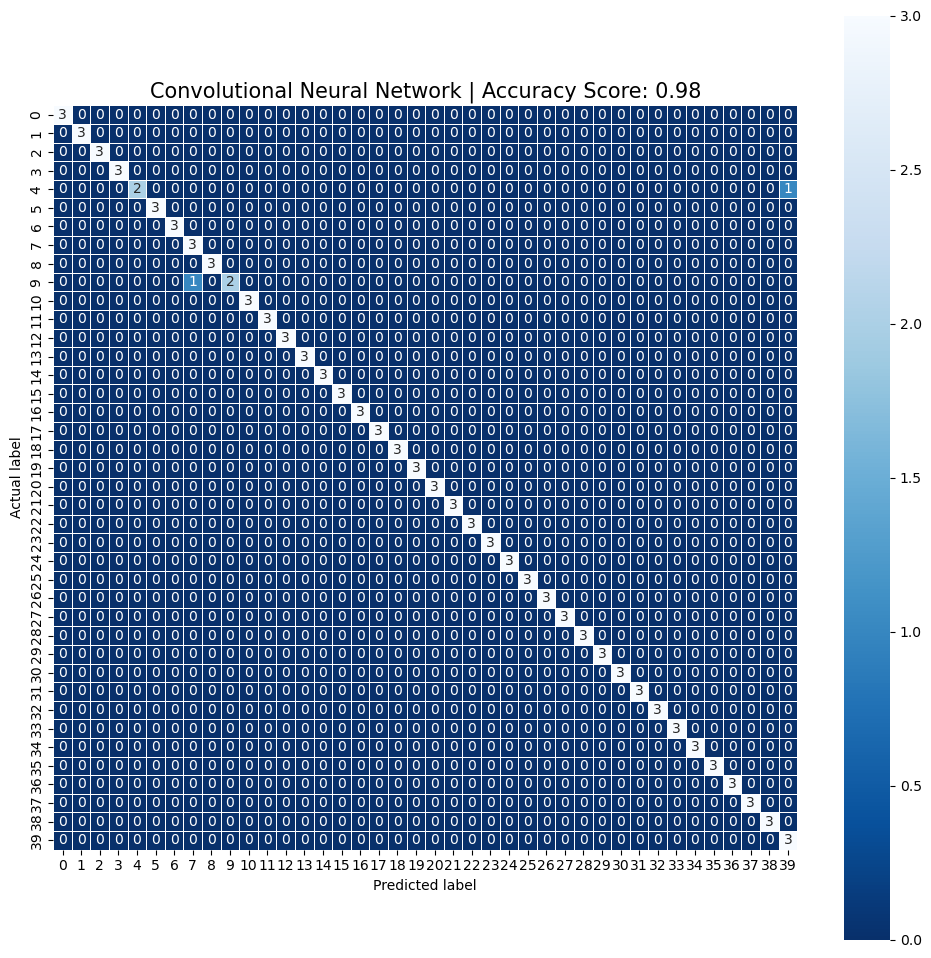

In [83]:
print(metrics.classification_report(y_test_2d.argmax(axis=1), model_final.predict(X_test_2d).argmax(axis=1)))

cm = metrics.confusion_matrix(y_test_2d.argmax(axis=1), model_final.predict(X_test_2d).argmax(axis=1))
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Convolutional Neural Network | Accuracy Score: {0}'.format(round(metrics.accuracy_score(y_test_2d.argmax(axis=1), model_final.predict(X_test_2d).argmax(axis=1)),2))
plt.title(all_sample_title, size = 15)
plt.show()

### Save the CNN model

In [101]:
model_final.save('cnn_model.h5')

### Transfer learning

The last model we will be training is a transfer learning model, using the VGG16 model as a base. We will be using the VGG16 model as a feature extractor, and we will be training a single layer neural network on top of it. The model will be trained on the augmented train set, with each image repeated 3 times, because the pretrained VGG16 model expects 3-channel images. 

We will train the model for 50 epochs, and the rest of the hyperparameters are the same as the previous model.

In [95]:
vgg16 = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(64,64,3))
vgg16.trainable = False
model_transfer = keras.Sequential()
model_transfer.add(vgg16)
model_transfer.add(keras.layers.Flatten())
model_transfer.add(keras.layers.Dense(40, activation='softmax'))
model_transfer.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train_augmented_3channels = np.repeat(X_train_augmented_2d, 3, axis=3)
X_test_3channels = np.repeat(X_test_2d, 3, axis=3)
y_train_augmented_3channels = to_categorical(y_train_augmented)
y_test_3channels = to_categorical(y_test)

history_transfer=model_transfer.fit(X_train_augmented_3channels, y_train_augmented_3channels, epochs=50, batch_size=32)


Epoch 1/50
140/140 [==============================] - 176s 1s/step - loss: 2.6773 - accuracy: 0.3982
Epoch 2/50
140/140 [==============================] - 166s 1s/step - loss: 1.4691 - accuracy: 0.7656
Epoch 3/50
140/140 [==============================] - 157s 1s/step - loss: 0.9958 - accuracy: 0.8699
Epoch 4/50
140/140 [==============================] - 158s 1s/step - loss: 0.7577 - accuracy: 0.8998
Epoch 5/50
140/140 [==============================] - 157s 1s/step - loss: 0.5968 - accuracy: 0.9275
Epoch 6/50
140/140 [==============================] - 163s 1s/step - loss: 0.4977 - accuracy: 0.9438
Epoch 7/50
140/140 [==============================] - 160s 1s/step - loss: 0.4184 - accuracy: 0.9549
Epoch 8/50
140/140 [==============================] - 162s 1s/step - loss: 0.3617 - accuracy: 0.9589
Epoch 9/50
140/140 [==============================] - 168s 1s/step - loss: 0.3198 - accuracy: 0.9670
Epoch 10/50
140/140 [==============================] - 160s 1s/step - loss: 0.2808 - accura

### Evaluate the pretrained CNN's performance on the test set

Lastly we evaluate the model's performance on the test set, and we can see that the model has a 98% accuracy, practicaly the same as the SVM classifier and the CNN model. The reason why the pretrained CNN doesn't perform better than the simple convolutional neural network we built might be that the VGG16 was trained on a much larger dataset, and designed for 224x224 RGB images, so it might not be the best model for this problem (64x64 grayscale images).

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       0.75      1.00      0.86         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       0.75      1.00      0.86         3
           8       1.00      1.00      1.00         3
           9       1.00      0.67      0.80         3
          10       1.00      0.67      0.80         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       0.75      1.00      0.86         3
          16       1.00      1.00      1.00         3
          17       1.00    

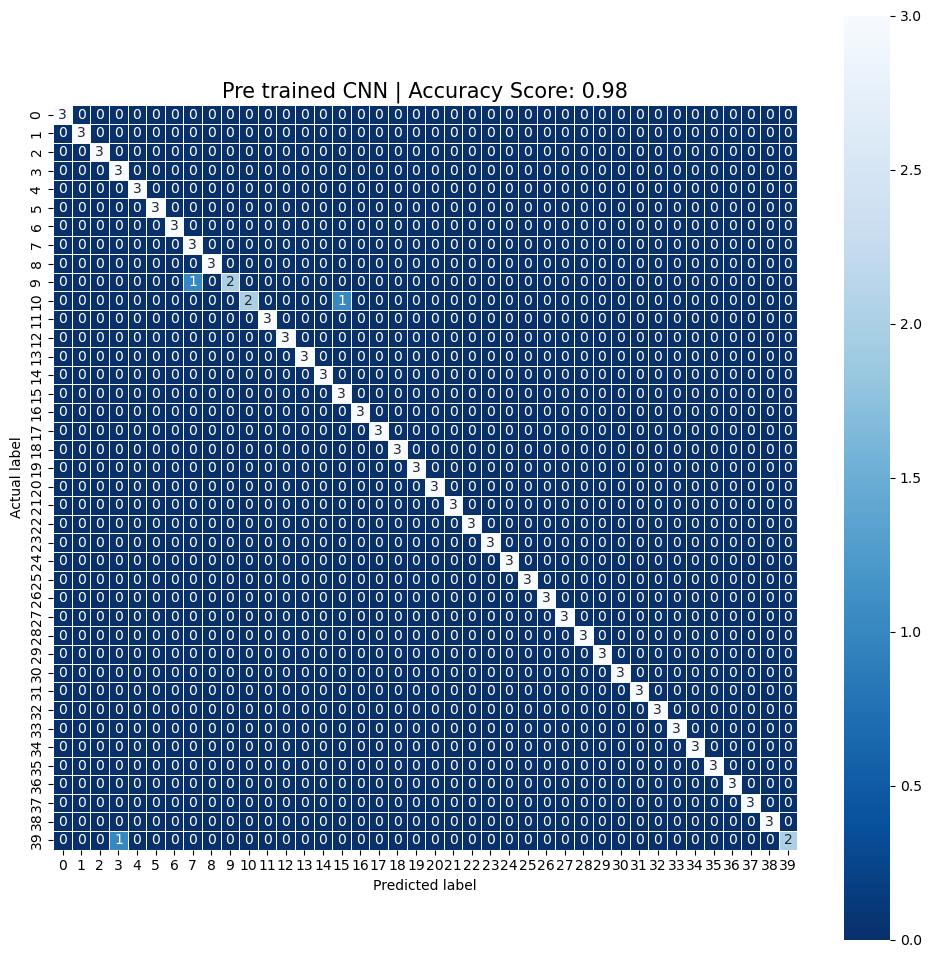

In [98]:
print(metrics.classification_report(y_test_3channels.argmax(axis=1), model_transfer.predict(X_test_3channels).argmax(axis=1)))

cm = metrics.confusion_matrix(y_test_3channels.argmax(axis=1), model_transfer.predict(X_test_3channels).argmax(axis=1))
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Pre trained CNN | Accuracy Score: {0}'.format(round(metrics.accuracy_score(y_test_3channels.argmax(axis=1), model_transfer.predict(X_test_3channels).argmax(axis=1)),2))
plt.title(all_sample_title, size = 15)
plt.show()

### Save the pretrained CNN model

In [102]:
model_transfer.save('pretrained_cnn_model.h5')